In [8]:
from pathlib import Path

import numpy as np
from joblib import Memory, Parallel, delayed

from dto import SimulationResult
from parse_log import Plan
from sim_core import calc_simulation_result  # ← импорт из модуля
from use_cases import PumpingPolicy

memory = Memory(location="cache_dir", verbose=0)


@memory.cache
def run_point(plan, pump_min_speed, pump_max_speed, tank_volume, pumping_policy, norma, max_speed):
    return calc_simulation_result(
        plan=plan,
        norma=norma,
        max_drone_speed=max_speed,
        pump_min_speed=pump_min_speed,
        pump_max_speed=pump_max_speed,
        tank_volume=tank_volume,
        pumping_policy=pumping_policy,
    )


In [3]:

log_file_path = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")
plan = Plan.get_plan_from_log_file(log_file_path)

norma_vals = np.linspace(0.5, 400.0, 100)
max_speed_vals = np.linspace(1.0, 11.0, 82)
X, Y = np.meshgrid(max_speed_vals, norma_vals)

pump_min_speed = 2
pump_max_speed = 13
tank_volume = 40
pumping_policy = PumpingPolicy.NoUnderfillPolicy

# параллельный запуск
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_point)(plan, pump_min_speed, pump_max_speed, tank_volume, pumping_policy, float(Y[i, j]), float(X[i, j]))
    for i in range(X.shape[0])
    for j in range(X.shape[1])
)

Z = np.array(results, dtype=object).reshape(X.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 2162 tasks      | elapsed:   36.9s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:   44.2s
[Parallel(n_jobs=8)]: Done 3026 tasks      | elapsed:   52.2s
[Parallel(n_jobs=8)]: Done 3512 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  1.2min
[P

In [10]:
r: SimulationResult = results[0]

In [12]:
r.volume_total

0.49471218751268753

In [5]:
len(results)

8200

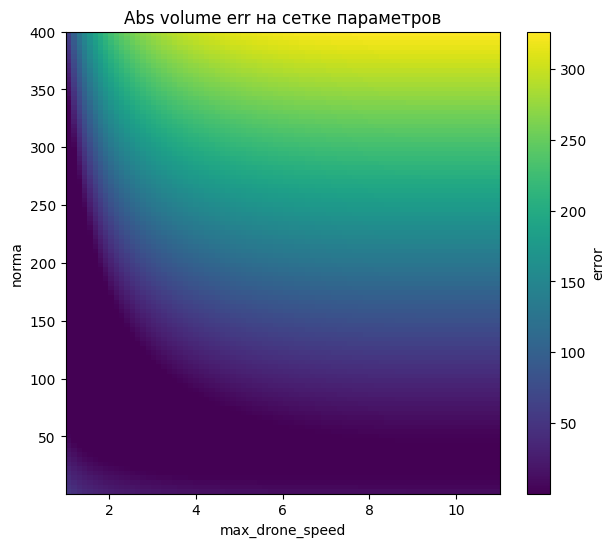

In [14]:
from matplotlib import pyplot as plt

# визуализация через imshow (матрица)
plt.figure(figsize=(7, 6))
plt.imshow(np.array([abs(r.volume_total - r.total_dispensed) for r in results], dtype=float).reshape(X.shape),
           extent=(X.min(), X.max(), Y.min(), Y.max()),
           origin="lower",
           aspect="auto",
           cmap="viridis")
plt.colorbar(label="error")
plt.xlabel("max_drone_speed")
plt.ylabel("norma")
plt.title("Abs volume err на сетке параметров")
plt.show()